# Compare Ground Motion Data 

Notebook testing the worklflow to compare ground motion data

## Input data preparation

Eeach key of the dictionary refers to the PE and contains the list (stream) of data passed on its input ports

In [14]:


input_data = {"streamProducerReal": 
                  [ {"input": "./misfit_data/output/IV.ARRO.EHR.data"} ], 
              "streamProducerSynth": 
                  [ {"input": "./misfit_data/output/IV.ARRO.HXR.synth"} ] 
             }

## Implementation of processing elements

The processing element can be developed within the notebook or imported from external modules (preprocessing_functions)


In [15]:
from dispel4py.core import GenericPE
from dispel4py.base import BasePE, IterativePE, ConsumerPE, create_iterative_chain
from dispel4py.workflow_graph import WorkflowGraph
from dispel4py.provenance import *
from dispel4py.seismo.seismo import SeismoPE

from obspy.core.stream import read
from obspy.signal.invsim import corn_freq_2_paz, simulate_seismometer
from obspy.signal import differentiate_and_integrate as di
import dispel4py.new.simple_process as simple_process

import math
import numpy as np
import os
import json
from collections import defaultdict

def calculate_norm(stream):
    station = stream[0].stats.station
    channels = set()
    for tr in stream:
        if station == tr.stats.station:
            channels.add(tr.stats.channel[-1])
        else:
            return None

    data_mean = None
    data_max = None
    if channels < set(['R','T']) or channels < set(['N','E']):

        if len(stream) == 1:
            return stream[0].data.copy(), stream[0].data.copy(), None

        for tr in stream:
            d = tr.data.copy()
            if data_mean is None:
                data_mean = np.square(d)
                data_max = np.abs(d)
            else:
                data_mean = data + np.square(d)
                data_max = data + np.abs(d)

        data_mean = np.sqrt(data)
        data_max = np.max(data)

    return data_mean, data_max, d

def calculate_pgm(data, ty, delta):
    pgm = max(abs(data))
    if ty == 'velocity':
        pgv = pgm
        int_data = di.integrate_cumtrapz(data, delta)
        pgd = max(abs(int_data))
        grad_data = np.gradient(data, delta)
        pga = max(abs(grad_data))
    elif ty == 'displacement':
        pgd = pgm
        grad_data = np.gradient(data, delta)
        pgv = max(abs(grad_data))
        grad2_data = np.gradient(grad_data, delta)
        pga = max(abs(grad2_data))
    elif ty == 'acceleration':
        pga = pgm
        int_data = di.integrate_cumtrapz(data, delta)
        pgv = max(abs(int_data))
        int2_data = di.integrate_cumtrapz(int_data, delta)
        pgd = max(abs(int2_data))
    return pgd, pgv, pga

def calculate_damped_spectral_acc(data,delta,freq,damp,ty):

    samp_rate = 1.0 / delta
    t = freq * 1.0
    d = damp
    omega = (2 * math.pi * t) ** 2

    paz_sa = corn_freq_2_paz(t, damp=d)
    paz_sa['sensitivity'] = omega
    paz_sa['zeros'] = []

    if ty == 'displacement':
        data = np.gradient(data, delta)
        data = np.gradient(data, delta)
    elif ty == 'velocity':
        data = np.gradient(data, delta)

    data = simulate_seismometer(data, samp_rate, paz_remove=None,
                            paz_simulate=paz_sa, taper=True,
                            simulate_sensitivity=True, taper_fraction=0.05)
    dmp_spec_acc = max(abs(data))

    return dmp_spec_acc


class StreamProducer(IterativePE):

    def __init__(self, label):
        IterativePE.__init__(self)
        self.label = label

    def _process(self, input):
        filename = input
        self.write('output', [read(filename), self.label])


class NormPE(GenericPE):
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input("input")
        self._add_output("output_mean")
        self._add_output("output_max")

    def _process(self, data):
        stream, filename = data['input']
        data_mean, data_max, d = calculate_norm(stream)
        self.write('output_mean', [stream, filename, data_mean, 'mean'])
        self.write('output_max', [stream, filename, data_max, 'max'])


class PeakGroundMotion(IterativePE):
    def __init__(self,ty,freq=(0.3, 1.0, 3.0),damp=0.1):
        IterativePE.__init__(self)
        self.ty=ty
        self.frequencies = freq
        self.damp = damp

    def _process(self, s_data):
        stream, filename, data, p_norm = s_data
        delta = stream[0].stats.delta
        pgd, pgv, pga = calculate_pgm(data, self.ty, delta)
        dmp_spec_acc = {}
        for freq in self.frequencies:
            dmp = calculate_damped_spectral_acc(data, delta, freq, self.damp, self.ty)
            dmp_spec_acc['PSA_{}Hz'.format(freq)] = dmp.item()

        results = {
            'PGD': pgd.item(),
            'PGV': pgv.item(),
            'PGA': pga.item(),
            'p_norm': p_norm
        }
        results.update(dmp_spec_acc)
        self.write('output', [
            stream[0].stats.station,
            filename, stream, self.ty, results]
        )


class Match(GenericPE):
    def __init__(self):
        GenericPE.__init__(self)
        self._add_input('input', grouping=[0])
        self._add_output('output')
        self.store = defaultdict(lambda: {})

    def _process(self, data):
        station, label,stream, ty, pgm = data['input']
        p_norm = pgm['p_norm']
        self.store[(station, p_norm)][label] = stream, ty, pgm
        if len(self.store[(station, p_norm)]) >= 2:
            print('output: {} {}'.format(station, p_norm))
            self.write('output', [station, p_norm, self.store[(station, p_norm)]])
            del self.store[station, p_norm]


def comp(real_param, synt_param):
    result_diff = real_param - synt_param
    result_rel_diff = (real_param - synt_param)/real_param
    return result_diff, result_rel_diff


class WriteGeoJSON(ConsumerPE):
    def __init__(self):
        ConsumerPE.__init__(self)
        self._add_output('output')

    def _process(self, data):
        station, p_norm, matching_data = data

        difference = { }
        relative_difference = {}
        stream_r, ty_r, pgm_r = matching_data['real']
        stream_s, ty_s, pgm_s = matching_data['synth']
        try:
            sac = stream_r[0].stats.sac
            coordinates = [sac.stla.item(), sac.stlo.item()]
        except:
            coordinates = []
        for param in pgm_r:
            if param == 'p_norm':
                continue
            diff, rel_diff = comp(pgm_r[param], pgm_s[param])
            difference[param] = diff
            relative_difference[param] = rel_diff

        output_dir="./GM/"
        output_data={
            "type": "Feature",
            "properties": {
                "station": station,
                "data": pgm_r,
                "synt": pgm_s,
                "difference": difference,
                "relative_difference": relative_difference,
                "geometry": {
                  "type": "Point",
                  "coordinates": coordinates
                }
            }
        }
        # self.log("output_data is %s" % json.dumps(output_data))
        filename = "./{}_{}.json".format(station, p_norm)
        os.makedirs(os.path.dirname(output_dir+filename), exist_ok=True)
        with open(output_dir+filename, 'w') as outfile:
            json.dump(output_data, outfile)
            self.write('output',output_data,location=output_dir+filename)
            
        


## Workflow Composition

The workflow can be composed. 

The main processing chain structure and parameters can be imported by reading an external JSON file (environment variable MISFIT_PREP_CONFIG). 

The create_processing_chain function will automatically compose the pipelines

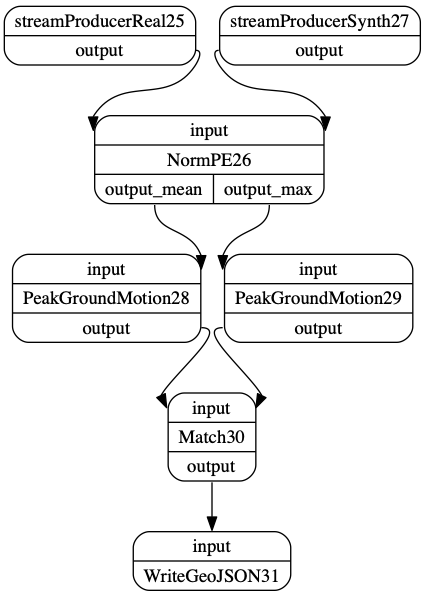

In [16]:

    
def buildWorkflow():
    streamProducerReal=StreamProducer('real')
    streamProducerReal.name="streamProducerReal"
    streamProducerSynth=StreamProducer('synth')
    streamProducerSynth.name='streamProducerSynth'
    norm=NormPE()
    pgm_mean=PeakGroundMotion('velocity')
    pgm_max=PeakGroundMotion('velocity')
    match = Match()
    write_stream = WriteGeoJSON()


    graph = WorkflowGraph()
    graph.connect(streamProducerReal, 'output', norm,'input')
    graph.connect(streamProducerSynth, 'output', norm,'input')
    graph.connect(norm, 'output_mean', pgm_mean,'input')
    graph.connect(norm, 'output_max', pgm_max,'input')
    graph.connect(pgm_max, 'output', match, 'input')
    graph.connect(pgm_mean, 'output', match, 'input')
    graph.connect(match,'output',write_stream,'input')
    
    return graph
    

graph=buildWorkflow() 

from dispel4py.visualisation import display
display(graph)

In [17]:
#!python -m dispel4py.new.processor simple create_misfit_prep.py -f misfit_input.jsn

## Execution without Provenance

In [18]:
def runExampleWorkflow(graph):
                                                     
                      
    graph.flatten()
    #Launch in simple process
    result = simple_process.process_and_return(graph, input_data)
    print("\n RESULT: "+str(result))

runExampleWorkflow(graph)

output: ARRO max
output: ARRO mean
SimplePE: Processed 1 iteration.

 RESULT: {'WriteGeoJSON31': {'output': [{'type': 'Feature', 'properties': {'station': 'ARRO', 'data': {'PGD': 3.058278835623448e-05, 'PGV': 0.00015388004669931565, 'PGA': 0.0008036469493372519, 'p_norm': 'max', 'PSA_0.3Hz': 0.00019936965175961448, 'PSA_1.0Hz': 0.001993187815127749, 'PSA_3.0Hz': 0.0009571555592350612}, 'synt': {'PGD': 0.00020578953253432437, 'PGV': 0.0013768559118028875, 'PGA': 0.010435016355026767, 'p_norm': 'max', 'PSA_0.3Hz': 0.0008818874950994615, 'PSA_1.0Hz': 0.01639742996418379, 'PSA_3.0Hz': 0.01445270888331235}, 'difference': {'PGD': -0.00017520674417808988, 'PGV': -0.001222975865103572, 'PGA': -0.009631369405689514, 'PSA_0.3Hz': -0.000682517843339847, 'PSA_1.0Hz': -0.014404242149056041, 'PSA_3.0Hz': -0.01349555332407729}, 'relative_difference': {'PGD': -5.728932958540158, 'PGV': -7.947592240424053, 'PGA': -11.984577821930724, 'PSA_0.3Hz': -3.4233788207784888, 'PSA_1.0Hz': -7.2267360053738, 'PSA

/anaconda3/lib/python3.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


## Provenance Storage

The provenance acquisition endpoints (API) are specified. Alternatively, the provenance document can be stored locally in the PROV_PATH 

In [19]:
#Store via service

ProvenanceType.REPOS_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/insert'
ProvenanceType.PROV_EXPORT_URL='http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/'

#Store to local path
ProvenanceType.PROV_PATH='./prov-files/'

#Size of the provenance bulk before sent to storage or sensor
ProvenanceType.BULK_SIZE=1


## Provenance Configuration

The workflow can be configured to capture provenance and lineage information by populating a json dictionary, according to specific metadata and precision requirements.

- 's-prov:componentsType': assigns provenance types and clusters to the workflow element overriding defaults
- 's-prov:WFExecutionInputs': specifies the initial input data of the workflow. Anything relevant can be mentioned in a list of dictionaries

In [20]:
prov_config =  {
                    'provone:User': "aspinuso", 
                    's-prov:description' : "PGA Comparison",
                    's-prov:workflowName': "demo_epos",
                    's-prov:workflowType': "seis:pga_comparison",
                    's-prov:workflowId'  : "workflow pga",
                    's-prov:save-mode'   : 'service'         ,
                    's-prov:WFExecutionInputs':  [{
                        "url": "",
                        "mime-type": "text/json",
                        "name": "input_data"
                        
                         
                     }],
                    # defines the Provenance Types and Provenance Clusters for the Workflow Components
                    's-prov:componentsType' : 
                                       {'streamProducerReal': {'s-prov:type':(SeismoPE,),
                                                     's-prov:prov-cluster':'seis:Processor'},
                                        'streamProducerSynth':    {'s-prov:prov-cluster':'seis:DataHandler',
                                                           's-prov:type':(SeismoPE,)},
                                        'Match': {'s-prov:prov-cluster':'seis:DataHandler',
                                                           's-prov:type':(AccumulateFlow,)},
                                        },
                    's-prov:sel-rules': None
                } 

Once the provenance requirements are set, the graph is prepared for provenance recording

Change grouping implementation 
Match Original base class: (<class 'dispel4py.core.GenericPE'>,)
 New type: (<class 'dispel4py.provenance.AccumulateFlow'>, <class '__main__.Match'>)
NormPE Original base class: (<class 'dispel4py.core.GenericPE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.NormPE'>)
PeakGroundMotion Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.PeakGroundMotion'>)
PeakGroundMotion Original base class: (<class 'dispel4py.base.IterativePE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.ProvenanceType'>, <class '__main__.PeakGroundMotion'>)
WriteGeoJSON Original base class: (<class 'dispel4py.base.ConsumerPE'>,)
(<class 'dispel4py.provenance.ProvenanceType'>,)
 New type: (<class 'dispel4py.provenance.Provenan

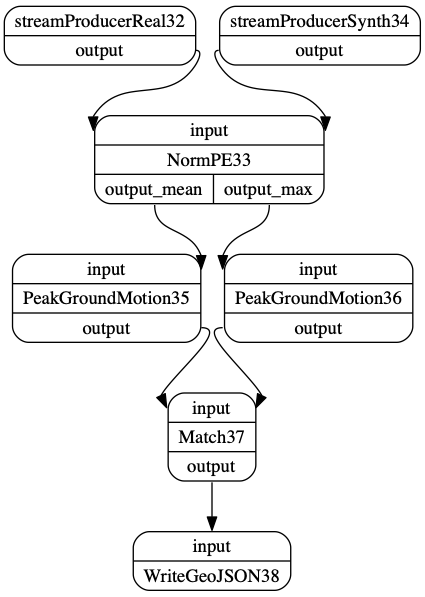

In [21]:
def createGraphWithProv():
    
    graph = buildWorkflow()
    # Ranomdly generated unique identifier for the current run
    rid='JUP_PGA_'+getUniqueId()

    
    # Finally, provenance enhanced graph is prepared:
    

     
    #Initialise provenance storage to service:
    configure_prov_run(graph, 
                     provImpClass=(ProvenanceType,),
                     input=prov_config['s-prov:WFExecutionInputs'],
                     username=prov_config['provone:User'],
                     runId=rid,
                     description=prov_config['s-prov:description'],
                     workflowName=prov_config['s-prov:workflowName'],
                     workflowType=prov_config['s-prov:workflowType'],
                     workflowId=prov_config['s-prov:workflowId'],
                     save_mode=prov_config['s-prov:save-mode'],
                     componentsType=prov_config['s-prov:componentsType'],
                     sel_rules=prov_config['s-prov:sel-rules']
                      
                    )
    
    return graph,rid


graph,rid=createGraphWithProv()

display(graph)

## Execution with Provenance

In [22]:
runExampleWorkflow(graph)


streamProducerReal32: BUILDING INITIAL DERIVATION
streamProducerSynth34: BUILDING INITIAL DERIVATION


/anaconda3/lib/python3.7/site-packages/obspy/signal/detrend.py:31: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(data.dtype, float):


output: ARRO max
output: ARRO mean
streamProducerReal32: Postprocess: (200, 'OK', b'{"inserts": ["streamProducerReal32_write_orfeus-as-15842-ed9bc5b6-43e4-11e9-83fa-f45c89acf865"], "success": true}')
streamProducerSynth34: Postprocess: (200, 'OK', b'{"inserts": ["streamProducerSynth34_write_orfeus-as-15842-ed9c31b8-43e4-11e9-83fa-f45c89acf865"], "success": true}')
SimplePE: Processed 1 iteration.

 RESULT: {'WriteGeoJSON38': {'output': [{'_d4p': {'type': 'Feature', 'properties': {'station': 'ARRO', 'data': {'PGD': 3.058278835623448e-05, 'PGV': 0.00015388004669931565, 'PGA': 0.0008036469493372519, 'p_norm': 'max', 'PSA_0.3Hz': 0.00019936965175961448, 'PSA_1.0Hz': 0.001993187815127749, 'PSA_3.0Hz': 0.0009571555592350612}, 'synt': {'PGD': 0.00020578953253432437, 'PGV': 0.0013768559118028875, 'PGA': 0.010435016355026767, 'p_norm': 'max', 'PSA_0.3Hz': 0.0008818874950994615, 'PSA_1.0Hz': 0.01639742996418379, 'PSA_3.0Hz': 0.01445270888331235}, 'difference': {'PGD': -0.00017520674417808988, 'P

## Extract Provenance 

The complete workflow's run lineage can be extracted in different formats (xml|rdf)

In [23]:
import xml.etree.ElementTree as ET

print("Extract Trace for run: "+rid)
expurl = urlparse(ProvenanceType.PROV_EXPORT_URL)
connection = httplib.client.HTTPConnection(expurl.netloc)
url="http://"+expurl.netloc+expurl.path+rid+"/export?level=100&format=xml"

print(url)
connection.request(
                "GET", url)
response = connection.getresponse()
  
print("progress: " + str((response.status, response.reason)))
prov1 = ET.fromstring(response.read())
print('PROV TO EMBED:')
print(str(prov1))

Extract Trace for run: JUP_PGA_orfeus-as-15842-ec65b60c-43e4-11e9-83fa-f45c89acf865
http://ec2-18-197-219-251.eu-central-1.compute.amazonaws.com/workflowexecutions/JUP_PGA_orfeus-as-15842-ec65b60c-43e4-11e9-83fa-f45c89acf865/export?level=100&format=xml
progress: (200, 'OK')
PROV TO EMBED:
<Element '{http://www.w3.org/ns/prov#}document' at 0x1c26a2bd68>


## Visualisation 

Once extracted, the provenance can be visualised in the notebook, 
Otherwise and more practical, would be to access it interactively in the sprovflow-viewer:

http://ec2-18-195-126-28.eu-central-1.compute.amazonaws.com/sprovflow-viewer/html/view.jsp

Entering the username will show a list of latest execution. Users can search and select which one to analyse.



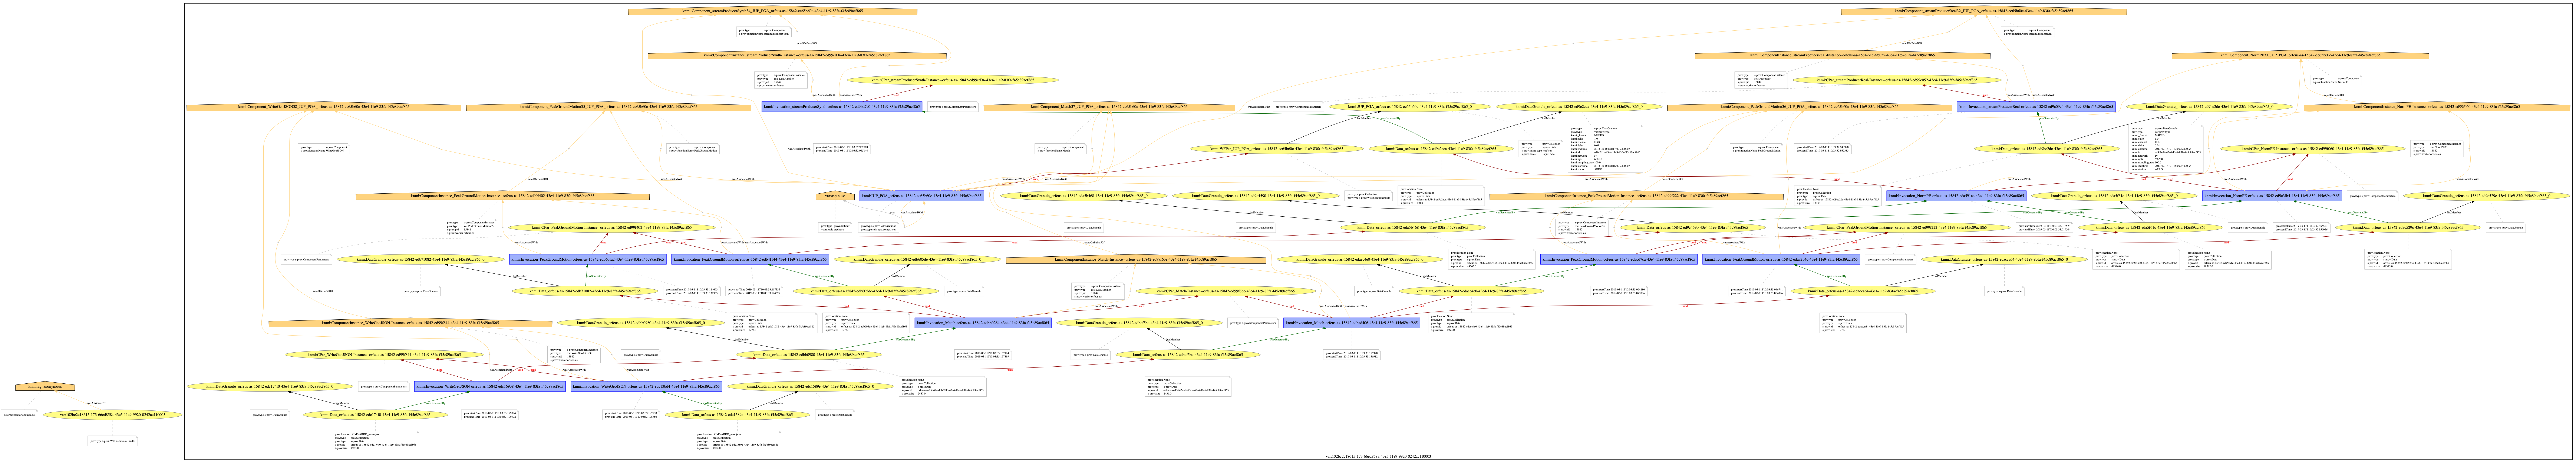

In [24]:
import prov
from IPython.display import Image
import io
from prov.model import ProvDocument, ProvBundle, ProvException, first, Literal
from prov.dot import prov_to_dot

def provURLToPNG(xml,format):
     
    xml_doc = io.BytesIO(urllib.request.urlopen(xml).read())
    doc=ProvDocument.deserialize(xml_doc,format="xml")
    dot = prov_to_dot(doc)
    
    if format=="png":
        dot.write_png('PROV.png')
        return 'PROV.png' 
    if format=="svg":
        dot.write_svg('PROV.svg')
        return 'PROV.svg'
    
    


png_content=provURLToPNG(url,"png")

Image(png_content)
